# Customer Segmentation Project
by: *Dorothy Kunth*

### Notebook 3 - Customer RFM Segmentation using Percentile Ranking

## Project Overview
The goal is to carry out segmentation of customers using the transaction history of an online gift store occurring between 01/12/2010 and 09/12/2011.

## Project Scope
1. Data Exploration
2. Data Preprocessing
3. Exploratory Data Analysis
4. **Customer RFM Segmentation using Percentile Ranking**
5. Customer RFM Segmentation using Kmeans Clustering

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

## Customer Segmentation based on RFM Metrics using Percentile Ranking
To perform customer segmentation using RFM, calculate customer behavior metrics:
1. **Recency** 
        - It measures how recent was each customer's last purchase. 
        - It is the number of days since the last transaction of the customer.
        - The lower it is, the better, since every business wants its customers to be recent and active.
2. **Frequency** 
        - It is a measure of how often customers buy from a company.
        - It calculates the number of orders placed by a customer over a defined period of time.
3. **Monetary Value** 
        - It measures how much has the customer spent within a given period.
        - It is the total value that the customer spent with the company within a given period.

#### Prepare the data
- To calculate recency, frequency, and monetary value, we need the following variables: date, invoice, and total_order_value
- To calculate recency, we need to have the most recent snapshot of data of today or yesterday, but since the data comes from 2010 and 2011, we will have to create a hypothetical snapshot date.

In [2]:
# Load the data

online_trans = pd.read_pickle('../data/online_trans.pkl')
online_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395624 entries, 2 to 399840
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            395624 non-null  object        
 1   stock_code         395624 non-null  object        
 2   description        395624 non-null  object        
 3   price              395624 non-null  float64       
 4   quantity           395624 non-null  int64         
 5   total_order_value  395624 non-null  float64       
 6   invoice_date       395624 non-null  datetime64[ns]
 7   customer_id        395624 non-null  object        
 8   country            395624 non-null  object        
 9   date               395624 non-null  object        
 10  period             395624 non-null  period[M]     
 11  dow                395624 non-null  object        
 12  hour               395624 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), 

In [3]:
# Check the start and end dates of transactions

print(f"Transactions timeframe from {online_trans['invoice_date'].min()} to {online_trans['invoice_date'].max()}")

Transactions timeframe from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


#### Task 1 - Create a hypothetical snapshot date

In [4]:
# Create hypothetical snapshot date

snapshot_date = online_trans['date'].max() + timedelta(days = 1)
print(snapshot_date)

2011-12-10


> A hypothetical snapshot date is created as the last invoice date plus 1 day since the data comes from 2010 and 2011.

#### Task 2 - Calculate RFM metrics

In [5]:
# Aggregate the data on a customer level

rfm = online_trans.groupby(['customer_id']).agg({
    'date': lambda x: (snapshot_date - x.max()).days,
    'invoice': 'nunique',
    'total_order_value': 'sum'})

# Rename columns
rfm.rename(columns = {
    'date': 'recency',
    'invoice': 'frequency',
    'total_order_value': 'monetary_value'}, inplace = True)

rfm

,recency,frequency,monetary_value
customer_id,,,
u12347,3,7,4310.00
u12348,76,4,1437.24
u12349,19,1,1457.55
u1235,311,1,294.40
u12352,37,8,1265.41
...,...,...,...
u1828,278,1,180.60
u18281,181,1,80.82
u18282,8,3,176.60


> **Note:**
> - ``nunique`` aggregation is used instead of ``count`` for the frequency metric (number of unique invoices per customer, instead of number of lines per customer)

In [6]:
rfm.describe()

,recency,frequency,monetary_value
count,4351.000000,4351.000000,4351.000000
mean,93.105493,4.862560,1899.486320
std,101.250679,8.910072,8275.427714
min,1.000000,1.000000,-1192.200000
25%,18.000000,1.000000,294.265000
50%,51.000000,2.000000,644.240000
75%,144.000000,5.000000,1589.095000
max,374.000000,239.000000,278778.020000


#### Task 3 - Group customers into tertiles (3-quantile) based on each of the RFM metrics and assign labels to each one of them

In [7]:
# Calculate recency tertiles
recency_tertiles = pd.qcut(rfm['recency'], q=3, labels = range(3, 0, -1))
rfm['R'] = recency_tertiles

# Calculate frequency tertiles
frequency_tertiles = pd.qcut(rfm['frequency'], q=3, labels = range(1, 4))
rfm['F'] = frequency_tertiles

# Calculate monetary value tertiles
monetary_tertiles = pd.qcut(rfm['monetary_value'], q=3, labels = range(1, 4))
rfm['M'] = monetary_tertiles

rfm.sort_values('recency')

,recency,frequency,monetary_value,R,F,M
customer_id,,,,,,
u13069,1,26,3714.94,3,3,3
u12713,1,1,794.55,3,1,2
u15311,1,116,59271.54,3,3,3
u14397,1,23,2556.68,3,3,3
u14422,1,6,4263.64,3,3,3
...,...,...,...,...,...,...
u18074,374,1,489.60,1,1,2
u14729,374,1,313.49,1,1,1
u16583,374,1,233.45,1,1,1


> **Note:**
> - The 3-quantiles was used instead of 4-quantiles due to the distribution of frequency metric where frequency value of 1 comprise of 31% of the total customers.
> - For the recency metric which calculates days since the last purchase, is better when it's low rather than high. Therefore, the values are reversed as lower recency is rated higher.

In [8]:
# Preview the top 10 largest sizes for frequency metric 

frequency_values = rfm['frequency'].value_counts()[:10].to_frame()
frequency_values['percent_to_total'] = frequency_values['frequency'] / len(rfm)
frequency_values

,frequency,percent_to_total
1,1377,0.316479
2,803,0.184555
3,490,0.112618
4,377,0.086647
5,274,0.062974
6,194,0.044587
7,150,0.034475
8,113,0.025971
11,70,0.016088
9,69,0.015858


#### Task 4 - Build RFM segments and calculate RFM scores

In [9]:
# Build RFM segments 
cols = ['R', 'F', 'M']
rfm['rfm_segment'] = rfm[cols].astype(str).apply(''.join, axis=1)

#Calculate RFM scores
rfm['rfm_score'] = rfm[cols].sum(axis=1)

rfm

,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score
customer_id,,,,,,,,
u12347,3,7,4310.00,3,3,3,333,9
u12348,76,4,1437.24,2,2,3,223,7
u12349,19,1,1457.55,3,1,3,313,7
u1235,311,1,294.40,1,1,1,111,3
u12352,37,8,1265.41,2,3,3,233,8
...,...,...,...,...,...,...,...,...
u1828,278,1,180.60,1,1,1,111,3
u18281,181,1,80.82,1,1,1,111,3
u18282,8,3,176.60,3,2,1,321,6


#### Analyze RFM segments

In [10]:
# Count the number of unique segments

rfm['rfm_segment'].nunique()

27

In [11]:
# Review the sizes of each rfm_segment

rfm.groupby(['rfm_segment']).size().sort_values(ascending=False)

rfm_segment
111    756
333    703
211    376
233    314
112    312
212    289
311    207
322    199
222    184
312    129
122    125
223    110
323     99
332     99
232     78
133     63
123     50
113     50
121     43
213     41
132     35
221     34
321     23
313     20
131      8
331      3
231      1
dtype: int64

In [12]:
# View top 10 rows of the lowest rfm_segment '111'

rfm[rfm['rfm_segment'] == '111'][:10]

,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score
customer_id,,,,,,,,
u1235,311,1,294.40,1,1,1,111,3
u12353,205,1,89.00,1,1,1,111,3
u12361,288,1,174.90,1,1,1,111,3
u12365,292,1,320.69,1,1,1,111,3
u12373,312,1,324.60,1,1,1,111,3
u12401,304,1,69.30,1,1,1,111,3
u12402,324,1,195.60,1,1,1,111,3
u12441,367,1,155.55,1,1,1,111,3
u1245,157,2,197.88,1,1,1,111,3


#### Calculate average RFM metrics and the count of customers per RFM score

In [13]:
# summary metrics per rfm_score

rfm.groupby(['rfm_score']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']}).round(1)

recency frequency monetary_value      
             mean      mean           mean count
rfm_score                                       
3           242.7       1.2          186.8   756
4           128.4       1.5          380.5   731
5            74.8       1.9          582.8   713
6            61.4       3.0         1032.6   463
7            46.2       4.4         1367.3   473
8            33.9       7.1         2497.6   512
9             9.6      15.2         7149.4   703

#### Use RFM score to segment customers

- RFM score of 9: Top-performing customers 
- RFM score of 7 and 8: Active customers 
- RFM score of 5 and 6: Unsteady customers
- RFM score of 4: Customers at risk 
- RFM score of 3: Inactive customers

#### Task 5 - Segment customers based on RFM scores

In [14]:
# Use RFM scores to group customers into named segments

rfm.loc[rfm['rfm_score'] == 3, 'customer_segment'] = 'Inactive customers'
rfm.loc[rfm['rfm_score'] == 4, 'customer_segment'] = 'Customers at risk'
rfm.loc[rfm['rfm_score'].between(5, 6, inclusive='both'), 'customer_segment'] = 'Unsteady customers'
rfm.loc[rfm['rfm_score'].between(7, 8, inclusive='both'), 'customer_segment'] = 'Active customers'
rfm.loc[rfm['rfm_score'] == 9, 'customer_segment'] = 'Top-performing customers'

rfm

,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,customer_segment
customer_id,,,,,,,,,
u12347,3,7,4310.00,3,3,3,333,9,Top-performing customers
u12348,76,4,1437.24,2,2,3,223,7,Active customers
u12349,19,1,1457.55,3,1,3,313,7,Active customers
u1235,311,1,294.40,1,1,1,111,3,Inactive customers
u12352,37,8,1265.41,2,3,3,233,8,Active customers
...,...,...,...,...,...,...,...,...,...
u1828,278,1,180.60,1,1,1,111,3,Inactive customers
u18281,181,1,80.82,1,1,1,111,3,Inactive customers
u18282,8,3,176.60,3,2,1,321,6,Unsteady customers


In [15]:
# Verify that the named segments belong to the correct rfm scores

rfm.groupby(['rfm_score'])['customer_segment'].unique()

rfm_score
3          [Inactive customers]
4           [Customers at risk]
5          [Unsteady customers]
6          [Unsteady customers]
7            [Active customers]
8            [Active customers]
9    [Top-performing customers]
Name: customer_segment, dtype: object

#### Calculate the summary metrics per customer segment

In [16]:
segment = rfm.groupby(['customer_segment']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)

segment.sort_values(by=('recency', 'mean'))

recency frequency monetary_value      
                            mean      mean           mean count
customer_segment                                               
Top-performing customers     9.6      15.2         7149.4   703
Active customers            39.8       5.8         1954.9   985
Unsteady customers          69.5       2.4          759.9  1176
Customers at risk          128.4       1.5          380.5   731
Inactive customers         242.7       1.2          186.8   756

#### Visualize customers per segment

In [17]:
rfm = rfm.reset_index()

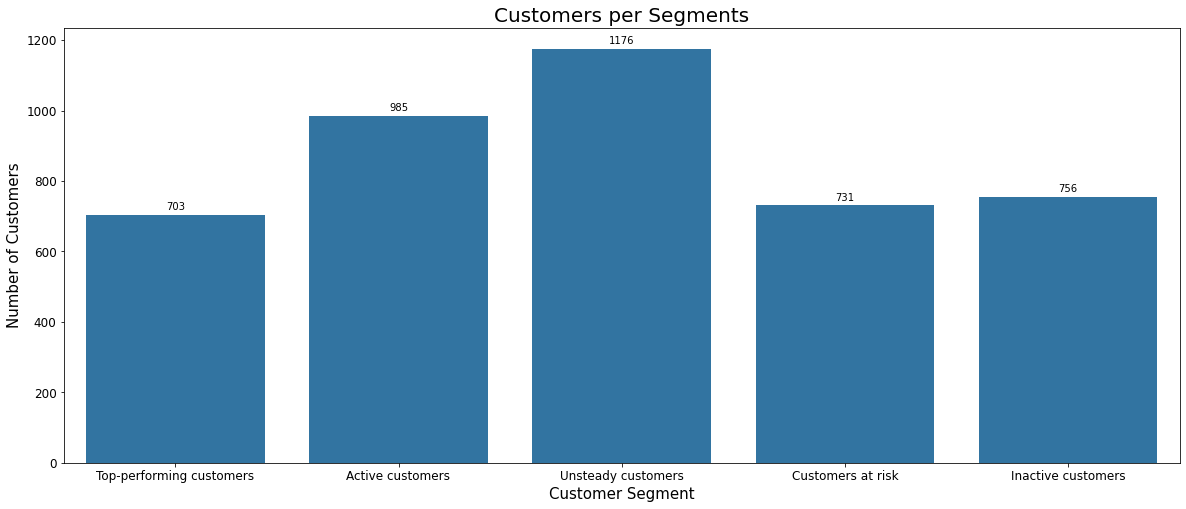

In [18]:
cust_segment = rfm.groupby(['customer_segment'])['customer_id'].nunique()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[0]
cat_order = ['Top-performing customers', 'Active customers', 'Unsteady customers', 'Customers at risk', 'Inactive customers']

ax = sns.barplot(x = cust_segment.index, y = cust_segment.values, color = base_color, order = cat_order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3)

plt.title('Customers per Segments', size=20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Number of Customers', size = 15)

plt.show();

#### Insights:

In [19]:
top_and_active = rfm['customer_segment'].isin(['Top-performing customers', 'Active customers']).sum()/len(rfm)*100
unsteady = (rfm['customer_segment'] == 'Unsteady customers').sum()/len(rfm)*100
at_risk_and_inactive = rfm['customer_segment'].isin(['Customers at risk', 'Inactive customers']).sum()/len(rfm)*100

print('The proportion of top-performing and active customers is', "{:.2f}".format(top_and_active),'%')
print('The proportion of unsteady customers is', "{:.2f}".format(unsteady),'%')
print('The proportion of customers at risk and inactive customers is', "{:.2f}".format(at_risk_and_inactive),'%')

The proportion of top-performing and active customers is 38.80 %
The proportion of unsteady customers is 27.03 %
The proportion of customers at risk and inactive customers is 34.18 %


> - The combined proportion of top and active customers is only 38.8% which means only 38.8% of customer base are making their purchases in an active manner
> - Unsteady customer make up the 27% of customer base which means that about 27% customers could either be active or inactive.
> - The combined proportion of customers at risk and inactive customers is 34%. These customers need to be reactivated and encouraged to make more purchases and frequently.

#### Marketing Campaign Recommendation:

- **Inactive customers** - Send personalized emails containing special offers with discounted or free items to encourage them to order and be active.<br><br>
- **Customers at risk** - This group of customers need attention as they made some purchases but it's been a long time since their last purchase. Send them personalized emails containing promotional items or free samples of products to encourage them to be more active.<br><br>
- **Unsteady customers** - This group of customers are not consistently inactive nor active. Send them emails with discounted or promo items for every occasion including birthdays, mother's day, father's day, Christmas etc.<br><br>
- **Active customers** - Create loyalty rewards program for this group where they can earn points for every purchase and convert these points into discount or voucher.<br><br>
- **Top customers** - Send birthday and anniversary cards with discount vouchers. Create a referral program where they can get discounts on the first purchase of their referrals.

In [20]:
rfm.head()

,customer_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,customer_segment
0,u12347,3,7,4310.00,3,3,3,333,9,Top-performing customers
1,u12348,76,4,1437.24,2,2,3,223,7,Active customers
2,u12349,19,1,1457.55,3,1,3,313,7,Active customers
3,u1235,311,1,294.40,1,1,1,111,3,Inactive customers
4,u12352,37,8,1265.41,2,3,3,233,8,Active customers


#### Task 6 - Create marketing campaign strategies based on customer segments

In [21]:
# Use customer segments to create marketing campaign strategies

rfm.loc[rfm['customer_segment'] == 'Top-performing customers', 'campaign_strategy'] = 'Send birthday and anniversary cards\
    with discount vouchers. Create a referral program where customers can get discounts on the first purchase of their \
    referrals.'
rfm.loc[rfm['customer_segment'] == 'Active customers', 'campaign_strategy'] = 'Create loyalty rewards program where \
    customers can earn points for every purchase and convert these points into discount or voucher.'
rfm.loc[rfm['customer_segment'] == 'Unsteady customers', 'campaign_strategy'] = "Send emails with discounted or \
    promotional items for every occasion, including birthdays, Mother's Day, Father's Day, and Christmas."
rfm.loc[rfm['customer_segment'] == 'Customers at risk', 'campaign_strategy'] = 'Send personalized emails containing \
    promotional items or free samples to encourage them to be more active.'
rfm.loc[rfm['customer_segment'] == 'Inactive customers', 'campaign_strategy'] = 'Send personalized emails containing special offers\
    with discounted or free items to encourage them to order and be active.'

rfm

,customer_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,customer_segment,campaign_strategy
0,u12347,3,7,4310.00,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...
1,u12348,76,4,1437.24,2,2,3,223,7,Active customers,Create loyalty rewards program where custo...
2,u12349,19,1,1457.55,3,1,3,313,7,Active customers,Create loyalty rewards program where custo...
3,u1235,311,1,294.40,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4,u12352,37,8,1265.41,2,3,3,233,8,Active customers,Create loyalty rewards program where custo...
...,...,...,...,...,...,...,...,...,...,...,...
4346,u1828,278,1,180.60,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4347,u18281,181,1,80.82,1,1,1,111,3,Inactive customers,Send personalized emails containing special of...
4348,u18282,8,3,176.60,3,2,1,321,6,Unsteady customers,Send emails with discounted or promotional...
4349,u18283,4,16,2039.58,3,3,3,333,9,Top-performing customers,Send birthday and anniversary cards with di...


#### Task 7 - Load the rfm dataframe as a csv file to local folder

In [22]:
# Load the rfm dataframe as a csv file to local folder

rfm.to_csv('../data/customer_rfm.csv', index=False)

#### Task 8 - Create a customer segment dataframe to only include customer id, customer segment, and campaign strategy variables

In [23]:
# Create df to only include customer id, customer segment and strategy

customer_segments = rfm[['customer_id', 'customer_segment', 'campaign_strategy']]
customer_segments

,customer_id,customer_segment,campaign_strategy
0,u12347,Top-performing customers,Send birthday and anniversary cards with di...
1,u12348,Active customers,Create loyalty rewards program where custo...
2,u12349,Active customers,Create loyalty rewards program where custo...
3,u1235,Inactive customers,Send personalized emails containing special of...
4,u12352,Active customers,Create loyalty rewards program where custo...
...,...,...,...
4346,u1828,Inactive customers,Send personalized emails containing special of...
4347,u18281,Inactive customers,Send personalized emails containing special of...
4348,u18282,Unsteady customers,Send emails with discounted or promotional...
4349,u18283,Top-performing customers,Send birthday and anniversary cards with di...


#### Task 8 -  Load the customer_segments dataframe to a csv in a local folder

In [24]:
# load the customer_segments df to a csv in local folder

customer_segments.to_csv('../data/customer_segments.csv', index=False)

In [25]:
online_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395624 entries, 2 to 399840
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            395624 non-null  object        
 1   stock_code         395624 non-null  object        
 2   description        395624 non-null  object        
 3   price              395624 non-null  float64       
 4   quantity           395624 non-null  int64         
 5   total_order_value  395624 non-null  float64       
 6   invoice_date       395624 non-null  datetime64[ns]
 7   customer_id        395624 non-null  object        
 8   country            395624 non-null  object        
 9   date               395624 non-null  object        
 10  period             395624 non-null  period[M]     
 11  dow                395624 non-null  object        
 12  hour               395624 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), 

## Customer Segments Analysis

In [26]:
# Create a dataframe to merge the preprocessed online trans dataframe and customer segments dataframe

online_trans_segmented = online_trans.merge(customer_segments, on = 'customer_id', how ='left')
online_trans_segmented

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,date,period,dow,hour,customer_segment,campaign_strategy
0,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,1.25,12,15.00,2010-12-07 14:57:00,u12347,Iceland,2010-12-07,2010-12,Tuesday,14,Top-performing customers,Send birthday and anniversary cards with di...
1,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,1.25,12,15.00,2010-12-07 14:57:00,u12347,Iceland,2010-12-07,2010-12,Tuesday,14,Top-performing customers,Send birthday and anniversary cards with di...
2,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,1.25,12,15.00,2010-12-07 14:57:00,u12347,Iceland,2010-12-07,2010-12,Tuesday,14,Top-performing customers,Send birthday and anniversary cards with di...
3,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,3.75,4,15.00,2010-12-07 14:57:00,u12347,Iceland,2010-12-07,2010-12,Tuesday,14,Top-performing customers,Send birthday and anniversary cards with di...
4,537626,85167B,BLACK GRAND BAROQUE PHOTO FRAME,1.25,30,37.50,2010-12-07 14:57:00,u12347,Iceland,2010-12-07,2010-12,Tuesday,14,Top-performing customers,Send birthday and anniversary cards with di...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395619,570715,21481,FAWN BLUE HOT WATER BOTTLE,3.75,4,15.00,2011-10-12 10:23:00,u18287,United Kingdom,2011-10-12,2011-10,Wednesday,10,Active customers,Create loyalty rewards program where custo...
395620,570715,23272,TREE T-LIGHT HOLDER WILLIE WINKIE,1.65,12,19.80,2011-10-12 10:23:00,u18287,United Kingdom,2011-10-12,2011-10,Wednesday,10,Active customers,Create loyalty rewards program where custo...
395621,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,1.25,36,45.00,2011-10-28 09:29:00,u18287,United Kingdom,2011-10-28,2011-10,Friday,9,Active customers,Create loyalty rewards program where custo...
395622,570715,85039A,SET/4 RED MINI ROSE CANDLE IN BOWL,1.45,48,69.60,2011-10-12 10:23:00,u18287,United Kingdom,2011-10-12,2011-10,Wednesday,10,Active customers,Create loyalty rewards program where custo...


#### 1. How much revenue were generated by each customer segment?

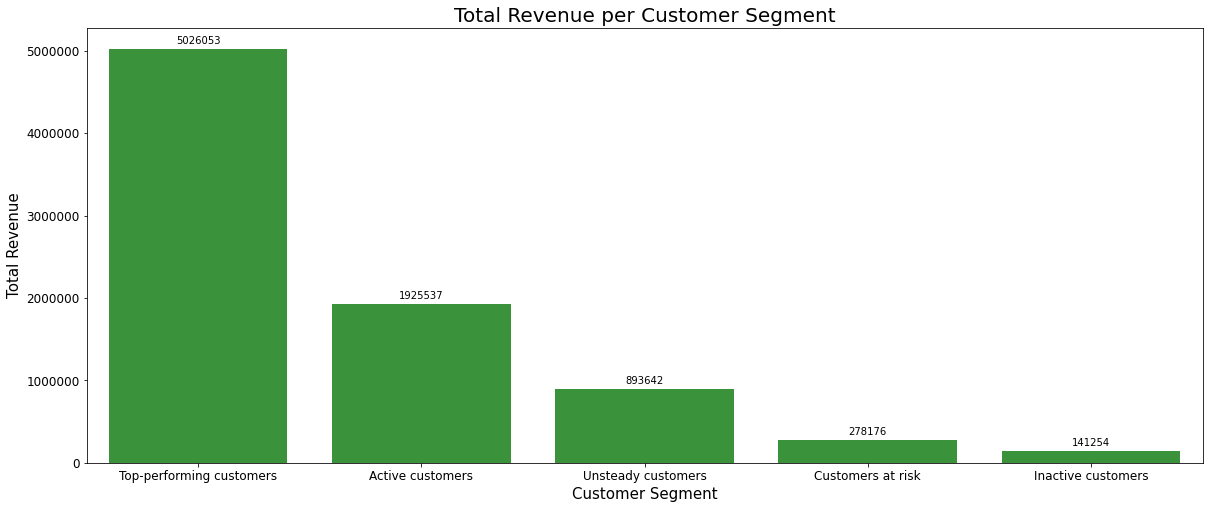

In [27]:
segment_rev = online_trans_segmented.groupby(['customer_segment'])['total_order_value'].sum()

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[2]

# Order to plot the categorical variables in
order = ['Top-performing customers', 'Active customers', 'Unsteady customers', 'Customers at risk', 'Inactive customers']

ax = sns.barplot(x = segment_rev.index, y = segment_rev.values, color = base_color, order = order)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3, fmt = '%d') # annotates bar plots with labels without scientific notation)

plt.title('Total Revenue per Customer Segment', size = 20)
plt.xlabel('Customer Segment', size = 15)
plt.ylabel('Total Revenue', size = 15)
yticks = [0, 1000000, 2000000, 3000000, 4000000, 5000000]
ax.set_yticklabels(yticks)
plt.show;

> Obviously top-performing customers generated the highest revenue and inactive customers had the lowest revenue.

#### 2. Which segment of customers generates the most revenue each month?

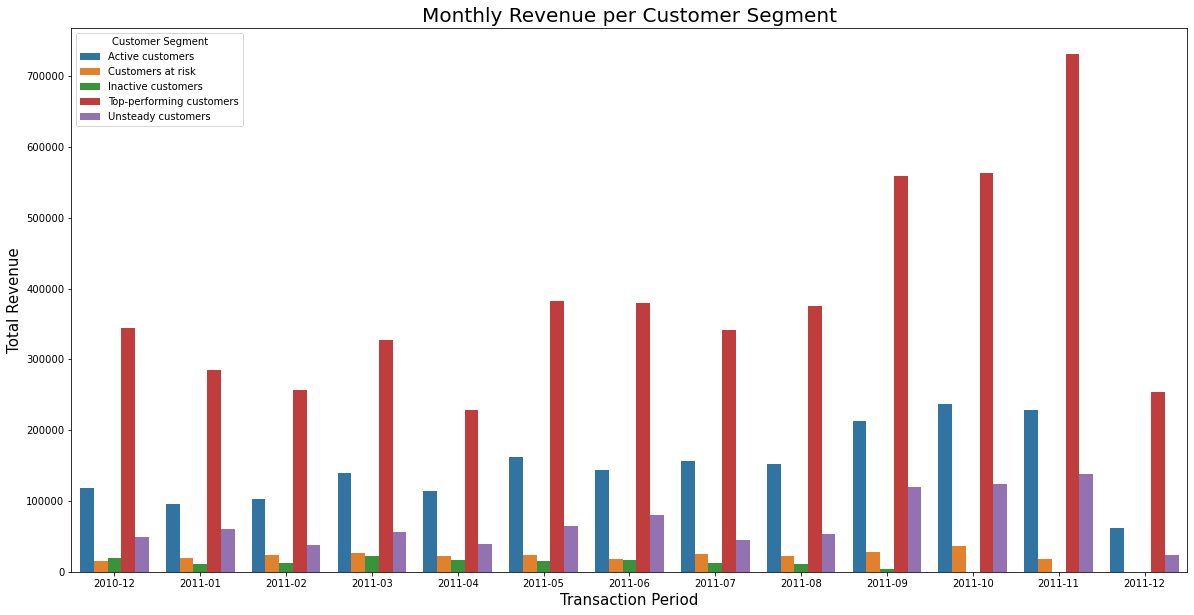

In [28]:
monthly_rev = online_trans_segmented.groupby(['period', 'customer_segment'])['total_order_value'].sum().reset_index()

plt.figure(figsize = [20, 10])
ax = sns.barplot(data= monthly_rev, x = 'period', y = 'total_order_value', 
               hue = 'customer_segment', errwidth=0)
plt.title("Monthly Revenue per Customer Segment", size=20)
plt.xlabel("Transaction Period", size=15)
plt.ylabel("Total Revenue", size=15)
ax.legend(loc = 2, ncol = 1, title = 'Customer Segment')
plt.show();


> - Top-performing customers consistently generated the most revenue per month
> - Inactive customers have not generated any sales revenue for the last 3 months.
> - During the last month, customers at risk did not generate sales revenue

#### 3. In which markets where our top-performing customers generated the top 5 highest revenues?

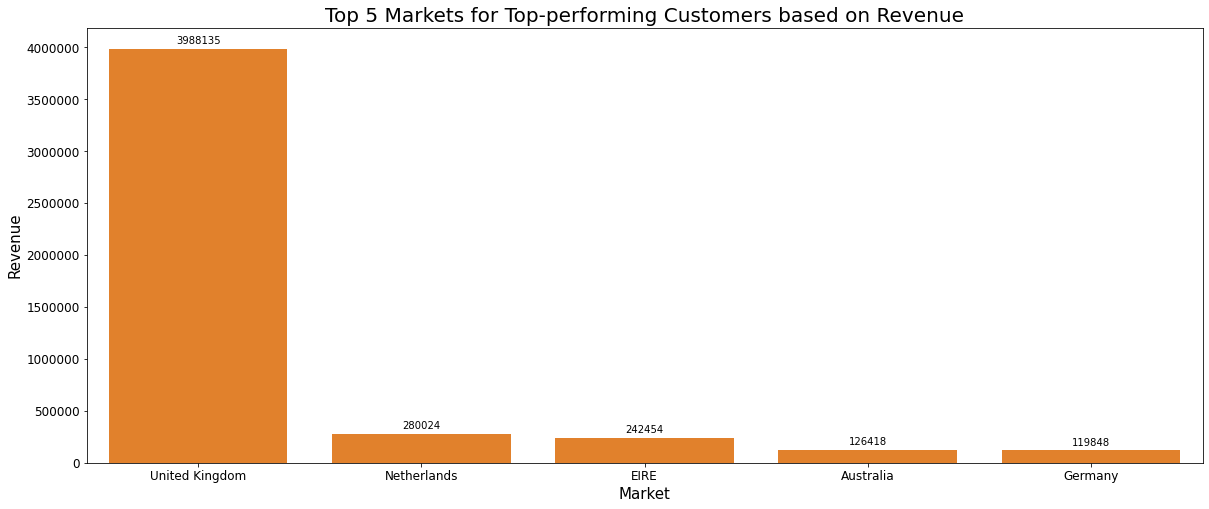

In [29]:
top_cust = online_trans_segmented[online_trans_segmented['customer_segment'] == 'Top-performing customers']
top5_market = top_cust.groupby(['country'])['total_order_value'].sum().sort_values(ascending = False)[:5]

plt.figure(figsize = [20, 8])
base_color = sns.color_palette()[1]

ax = sns.barplot(x = top5_market.index, y = top5_market.values, color = base_color)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.bar_label(ax.containers[0], padding = 3, fmt = '%d')# annotates bar plots with labels without scientific notation

plt.title('Top 5 Markets for Top-performing Customers based on Revenue', size = 20)
plt.xlabel('Market', size = 15)
plt.ylabel('Revenue', size = 15)
yticks = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]
ax.set_yticklabels(yticks)
plt.show;

> The top-performing customers who generated the most revenue were from the UK.

#### 4. In which period did the top-perfoming customers exceed the overall average monthly revenue?

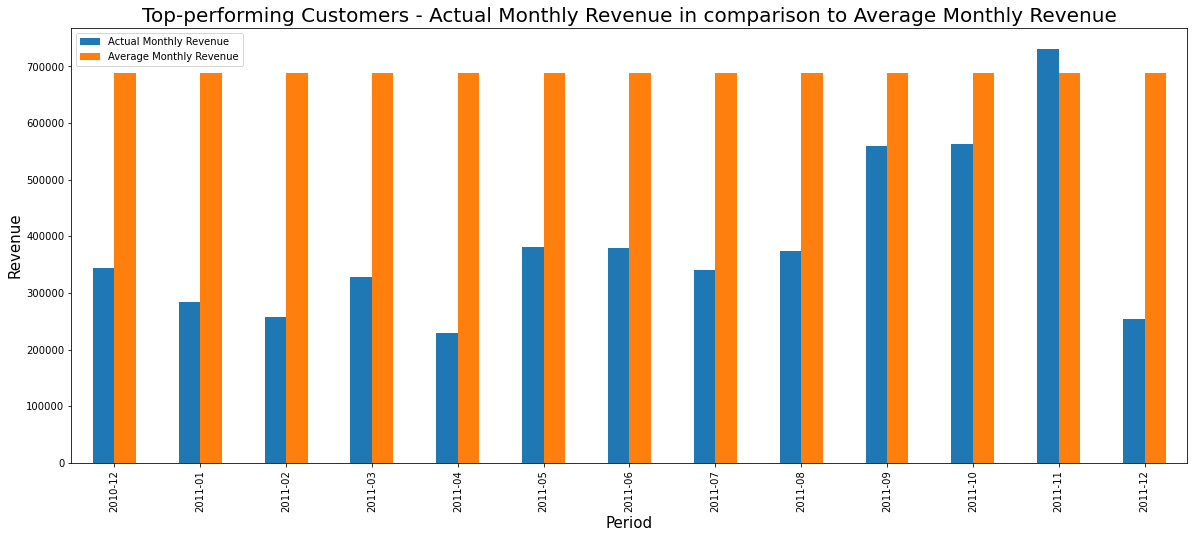

In [30]:
top_cust_monthly = top_cust.groupby(['period'])['total_order_value'].sum().reset_index()
top_cust_monthly['average_revenue'] = round(online_trans_segmented['total_order_value'].sum()/12, 2)

top_cust_monthly.plot(kind = 'bar', x = 'period', figsize = [20, 8])
plt.title('Top-performing Customers - Actual Monthly Revenue in comparison to Average Monthly Revenue', fontsize = 20)
plt.xlabel('Period', fontsize = 15)
plt.ylabel('Revenue', fontsize = 15)
plt.legend(['Actual Monthly Revenue', 'Average Monthly Revenue'])
plt.show()

> The top-performing customers exceeded overall monthly average revenue during November 2011.

#### 5. How much of the total orders are placed by top-performing customers?

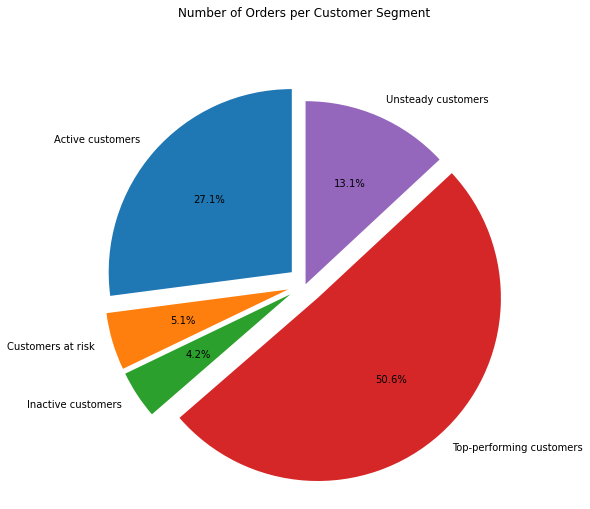

In [31]:
num_orders = online_trans_segmented.groupby(['customer_segment'])['invoice'].nunique()
num_orders.plot(kind = 'pie', labels = num_orders.index, autopct = '%1.1f%%', figsize = (20, 8), startangle = 90,
               explode=[0.1, 0.1, 0.1, 0.1, 0])
plt.axis('square')
plt.title ('Number of Orders per Customer Segment', pad = 50)
plt.ylabel('')
plt.show()

> 50% of the total orders are placed by top-performing customers.

#### 6. Which segment of customers generates the most revenue per day of the week?

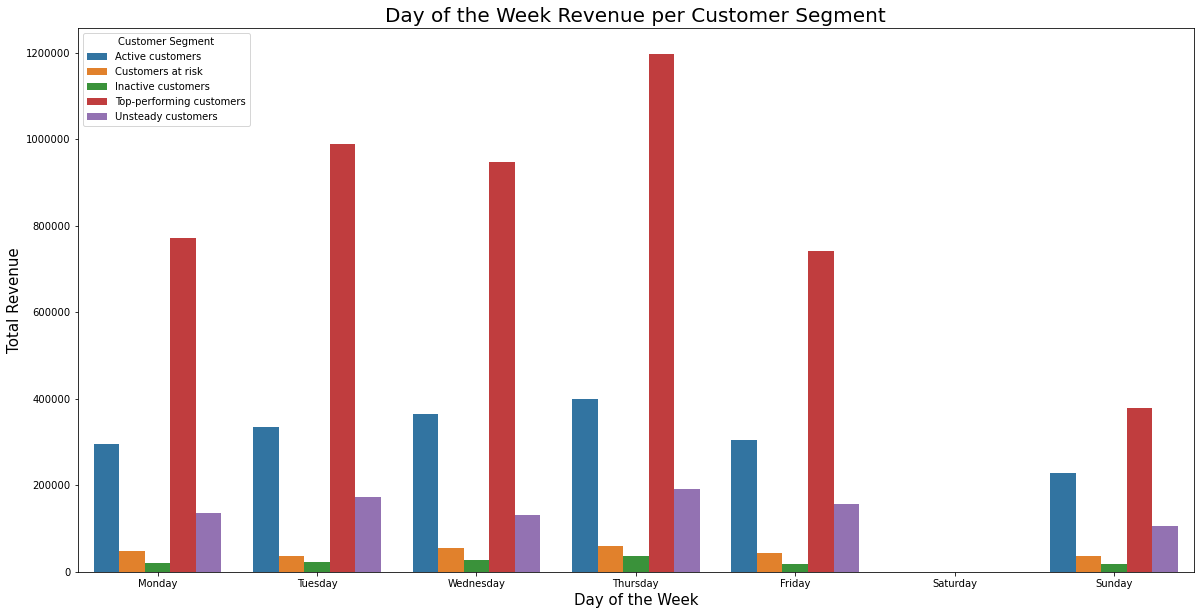

In [32]:
day_rev = online_trans_segmented.groupby(['dow', 'customer_segment'])['total_order_value'].sum().reset_index()

plt.figure(figsize = [20, 10])

# Order to plot the categorical variables in
cat_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


ax = sns.barplot(data= day_rev, x = 'dow', y = 'total_order_value', hue = 'customer_segment', 
                 errwidth=0, order = cat_order)
plt.title("Day of the Week Revenue per Customer Segment", size=20)
plt.xlabel("Day of the Week", size=15)
plt.ylabel("Total Revenue", size=15)
ax.legend(loc = 2, ncol = 1, title = 'Customer Segment')
yticks = [0, 200000, 400000, 600000, 800000, 1000000, 1200000]
ax.set_yticklabels(yticks)
plt.show();

> The top-performing customers consistently generated the highest revenue per day of the week.